## Классы

In [1]:
import numpy as np
import pandas  as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp


In [2]:
class RNG:
    rng_cfg__modulus = int(2**64 - 1)
    rbg_cfg__mul = 1103515245
    rbg_cfg__add = 12345


    def __init__(self, seed=2022) -> None:
        self._seed = seed

    def __next__(self):
        self._seed = (self.rbg_cfg__mul * self._seed + self.rbg_cfg__add) % self.rng_cfg__modulus
        return self._seed
        

class ContRandomGenerator:
    def __init__(self, rng, precision=5) -> None:
        self._rng = rng
        self._rng_precision = precision

        self._range = None

    def _uniform_dist(self):
        modulus = (10**self._rng_precision)
        return (next(self._rng) % modulus) / modulus

    def _cdf(self, x, condidtion=None):
        pass

    def _inverse_cdf(self, y, condition=None):
        pass
    
    def sample(self, n, condition=None):
        return [
            self._inverse_cdf(self._uniform_dist(), condition=condition) for _ in range(n)
        ]

class CondDiscreteRandomGenerator:
    def __init__(self, prob_tensor, axis, rng, precision=5) -> None:
        self._rng = rng
        self._rng_precision = precision

        self._raw_pdf_tensor = prob_tensor
        self._axis = axis

        self._range = None

    def _uniform_dist(self):
        modulus = (10**self._rng_precision)
        return (next(self._rng) % modulus) / modulus

    def _cdf(self, x, condidtion=None):
        pass

    def _inverse_cdf(self, y, condition=None):
        pass
    
    def sample(self, n, condition=None):
        return [
            self._inverse_cdf(self._uniform_dist(), condition=condition) for _ in range(n)
        ]



In [3]:
from sklearn.metrics import precision_score

import sympy
from random import random

x, y, z = sympy.symbols('x y z')
_expr = 1/2 * (sympy.sin(y) + sympy.sin(z) - sympy.sin(z + y)) / (sympy.sin(z)-sympy.cos(z) + 1) - x
#_inverse_cdf_expr = sympy.solve(_expr, y)
#_inverse_cdf_func = sympy.lambdify([x, z], _inverse_cdf_expr[0])
#print(_inverse_cdf_expr)

from sympy.calculus.util import *
f = sympy.sin(x + y) / (sympy.sin(x) + sympy.cos(x))
ivl = Interval(0,sympy.pi / 2)
print(stationary_points(f, y))


class RandomGenerator(ContRandomGenerator):
    def __init__(self, rng, precision=5) -> None:
        self._rng = rng
        self._rng_precision = precision

        self._range = (0, np.pi / 2)

        _expr = 1/2 * (sympy.sin(x) - sympy.cos(x) + 1) - y
        self._inverse_cdf_expr = sympy.solve(_expr, x)
        self._inverse_cdf_func = sympy.lambdify(y, self._inverse_cdf_expr[0])

    def _cdf(self, x):
        return 1/2 * (np.sin(x)-np.cos(x) + 1)

    def _inverse_cdf(self, y, condition=None):
        return self._inverse_cdf_func(y)

class ConditionalGenerator(ContRandomGenerator):
    def __init__(self, rng, precision=5) -> None:
        self._rng = rng
        self._rng_precision = precision

        self._range = (0,np.pi / 2)

    def _cdf(self, y, condition=None):
        _condition = condition[0]
        return (np.cos(_condition) - np.cos(_condition + y) / (np.cos(_condition) + np.sin(_condition)))

    def _inverse_cdf(self, x, condition=None):
        p = condition[0]

        is_equal = False
        while not is_equal:
            a = random() * np.pi / 2
            result = np.sin(a + p) / (np.sin(p) + np.cos(p))
            max = 1
            b = random() * max

            is_equal = b < result

        return a

        #return np.pi / -p + np.cosh(np.cos(p) - x * np.sin(p) - x * np.cos(p))

class MultiContRandomGenerator(ContRandomGenerator):
    def sample(self, n):
        def _sample_once(self):
            conditions = []
            for rv in self._rv_seq:
                conditions.append(rv.sample(n=1, condition=conditions)[0])
            return conditions

        return [_sample_once(self) for _ in range(n)]

Union(Intersection(ImageSet(Lambda(_n, -I*(I*(2*_n*pi + arg(I*exp(-I*x))) + im(x))), Integers), Reals), Intersection(ImageSet(Lambda(_n, -I*(I*(2*_n*pi + arg(-I*exp(-I*x))) + im(x))), Integers), Reals))


In [4]:
class MatrixComponentGenerator(CondDiscreteRandomGenerator):
    def __init__(self, prob_tensor, rng, precision=5) -> None:
        super().__init__(prob_tensor, 0, rng, precision)

        self._pdf_tensor = np.sum(self._raw_pdf_tensor, axis=1)

        self._range = [k for k in range(len(self._pdf_tensor))]
        self._raw_inverse_cdf = np.cumsum(self._pdf_tensor)

    def _cdf(self, x, condition=None):
        idx = self._range.index(x)
        return self._raw_inverse_cdf[idx]

    def _inverse_cdf(self, y, condition=None):
        idx_val = list(self._raw_inverse_cdf >= y).index(True)
        return self._range[idx_val]

class DependentMatrixComponentGenerator(CondDiscreteRandomGenerator):
    def __init__(self, prob_tensor, rng, precision=5) -> None:
        super().__init__(prob_tensor, 1, rng, precision)

        len(prob_tensor.shape) == 2

        self._pdf_tensor = self._raw_pdf_tensor

        self._range = [k for k in range(self._pdf_tensor.shape[1])]
        self._raw_inverse_cdf = np.cumsum(self._pdf_tensor, axis=1)
        self._raw_inverse_cdf = np.divide(self._raw_inverse_cdf, self._raw_inverse_cdf[:,-1].reshape(self._raw_inverse_cdf.shape[0],1))

    def _cdf(self, x, condition=None):
        _condition = condition[0]
        idx = self._range.index(x)
        return self._raw_inverse_cdf[_condition,idx]

    def _inverse_cdf(self, y, condition=None):
        _condition = condition[0]
        idx_val = list(self._raw_inverse_cdf[_condition,:] >= y).index(True)
        return self._range[idx_val]

class BiRVGenerator(MultiContRandomGenerator):
    def __init__(self, rng, precision=5) -> None:
        self._rv_seq = [
            RandomGenerator(rng),
            ConditionalGenerator(rng)
        ]
        
        super().__init__(rng, precision)

class MatrixBiRVGenerator(MultiContRandomGenerator):
    def __init__(self, matrix, rng, precision=5) -> None:
        self._rv_seq = [
            MatrixComponentGenerator(matrix, rng),
            DependentMatrixComponentGenerator(matrix, rng)
        ]
        
        super().__init__(rng, precision)

In [5]:
rng = RNG()

In [6]:
x_y_generator = RandomGenerator(rng=rng).sample
y_cond_generator = ConditionalGenerator(rng=rng).sample

In [7]:
from scipy.stats import norm, chi2

probability = 0.97

def get_delta(offset, tests):
    t = norm.ppf(probability / 2 + 0.5)
    return t * offset / np.sqrt(tests)

def get_offset_delta(test_offset, tests):
    alphas = ((1 - probability) / 2, (1 + probability) / 2)
    chis = (chi2.isf(alphas, tests - 1))
    temp = np.sqrt(tests - 1) * test_offset
    
    return (temp / np.sqrt(chis[0]), temp / np.sqrt(chis[1]))

# Задание 1, Вариант 2 (1/2 sin(x + y), 0 < x,y < pi/2)

## Гистограммы состовляющих X и Y (одинаковые)

Матожидание: 0.7853646602348157
Отклонение: 0.1876110391475642


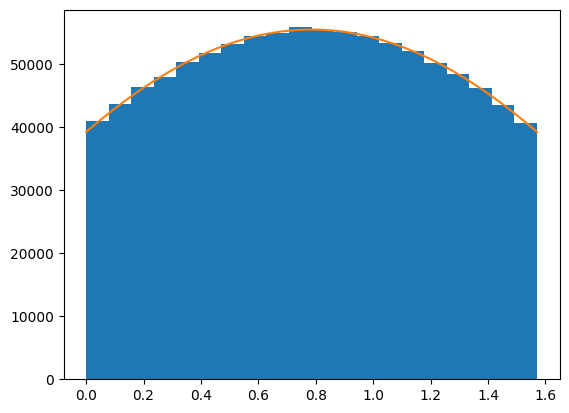

In [8]:
# f(x) = sqrt(2) / 2 * sin(x + pi/4)
# f(y|x) = np.sin(x + p) / (np.sin(p) + np.cos(p))

x_points = np.linspace(0, np.pi / 2, num=100)

tests = 10 ** 6
bins = 20
length = np.pi / 2 / 20

x_pdf = lambda x: (np.sqrt(2) / 2 * np.sin(x + np.pi / 4))
y_pdf = x_pdf

dist_points = x_pdf(x_points) * tests * length

fig, ax = plt.subplots()

samples = x_y_generator(tests)

print(f"Матожидание: {np.mean(samples)}")
print(f"Отклонение: {np.var(samples)}")

plt.hist(samples, bins=20)
_ = sns.lineplot(x=x_points, y=dist_points, ax=ax)

In [9]:
birv_generator = BiRVGenerator(rng).sample

In [10]:
samples = np.array(birv_generator(10**6))
n_bins = 31
bin_range = np.pi / 2  / n_bins

x_uncond_dist = np.array([len(samples[(samples[:,0] > bin_range * idx) & (samples[:,0] <= bin_range * (idx + 1))]) for idx in range(n_bins)]) / len(samples)
y_uncond_dist = np.array([len(samples[(samples[:,1] > bin_range * idx) & (samples[:,1] <= bin_range * (idx + 1))]) for idx in range(n_bins)]) / len(samples)

print("Сумма для проверки: ")
x_uncond_dist.sum()


Сумма для проверки: 


0.9999539999999999

In [11]:
def chi_criteria(ldist_binarized, rdist_binarized, n_samples):
    chi_res_stat = ((ldist_binarized - rdist_binarized) ** 2) / rdist_binarized
    return np.sum(chi_res_stat) * n_samples

def comp_indep_check(samples, axis, n_bins=31):
    n_bins = 31

    chis = []
    bin_range = 1 / n_bins
    uncond_dist = np.array([len(samples[(samples[:,axis] > bin_range * idx) & (samples[:,axis] <= bin_range * (idx + 1))]) for idx in range(n_bins)]) / len(samples)
    
    for idx in range(n_bins):
        l_bound, r_bound = bin_range * idx, bin_range * (idx + 1)

        valid_values = samples[(samples[:,int(not bool(axis))] <= r_bound) & (samples[:,int(not bool(axis))] <= r_bound), axis]
        
        n_subsample = len(valid_values)
        bins = np.array([len(valid_values[(valid_values > bin_range * idx) & (valid_values <= bin_range * (idx + 1))]) for idx in range(n_bins)]) / n_subsample

        chis.append(
            chi_criteria(bins, uncond_dist, n_subsample)
        )
        
    return chis

In [26]:
mean_X = sum(x_uncond_dist) / len(x_uncond_dist)
mean_Y = sum(y_uncond_dist) / len(y_uncond_dist)

deviations_X = [x - mean_X for x in x_uncond_dist]
deviations_Y = [y - mean_Y for y in y_uncond_dist]

sum_product_deviations = sum(deviations_X[i] * deviations_Y[i] for i in range(len(x_uncond_dist)))
sum_squared_deviations_X = sum(deviation ** 2 for deviation in deviations_X)
sum_squared_deviations_Y = sum(deviation ** 2 for deviation in deviations_Y)

correlation_coef = sum_product_deviations / math.sqrt(sum_squared_deviations_X * sum_squared_deviations_Y)

print("Коэффициент корреляции:", correlation_coef)

Коэффициент корреляции: -0.04320462998872688


## Характеристики

In [22]:
import scipy.stats as st

mean = (np.mean(samples, axis=0))
var = (np.var(samples, axis=0))
tests = 100000

print("Матожидание X и Y: ", mean)
x_mean_range = (mean[0] - get_delta(var[0], tests), mean[0] + get_delta(var[0], tests))
y_mean_range = (mean[1] - get_delta(var[1], tests), mean[1] + get_delta(var[1], tests))
print("Доверительный интервал матожидания X: ", x_mean_range)
print("Доверительный интервал матожидания Y: ", y_mean_range)
print()

print("Отклонение X и Y: ", var)
x_var_range = get_offset_delta(var[0], tests)
y_var_range = get_offset_delta(var[1], tests)
print("Доверительный интервал отклонения X: ", x_var_range)
print("Доверительный интервал отклонения Y: ", y_var_range)
print()

print("Теоретическое матожидание X и Y: integral_0^(π/2) 1/2 x (cos(x) + sin(x)) dx = π/4≈0.78540")
print("Теоретическое отклонение X и Y: integral_0^(π/2) 1/2 x^2 (cos(x) + sin(x)) dx - ( integral_0^(π/2) 1/2 x (cos(x) + sin(x)) dx)^2=0.187647")

r_xy = st.pearsonr(x_uncond_dist, y_uncond_dist)
print(f'Коэффициент коррелляции r[x, y]: {r_xy[0]}')

Матожидание X и Y:  [0.78475573 0.78609564]
Доверительный интервал матожидания X:  (0.7834693699808815, 0.786042093332465)
Доверительный интервал матожидания Y:  (0.7848077393604889, 0.7873835370149855)

Отклонение X и Y:  [0.18744993 0.18767392]
Доверительный интервал отклонения X:  (0.18654461007584322, 0.18836384659552796)
Доверительный интервал отклонения Y:  (0.18676752352583842, 0.18858893396139667)

Теоретическое матожидание X и Y: integral_0^(π/2) 1/2 x (cos(x) + sin(x)) dx = π/4≈0.78540
Теоретическое отклонение X и Y: integral_0^(π/2) 1/2 x^2 (cos(x) + sin(x)) dx - ( integral_0^(π/2) 1/2 x (cos(x) + sin(x)) dx)^2=0.187647
Коэффициент коррелляции: -0.04320462998872693


## Матрица ковариации

In [13]:
np.cov(samples, rowvar=False)

array([[ 0.18745011, -0.04607783],
       [-0.04607783,  0.18767411]])

## 3D Гистограмма

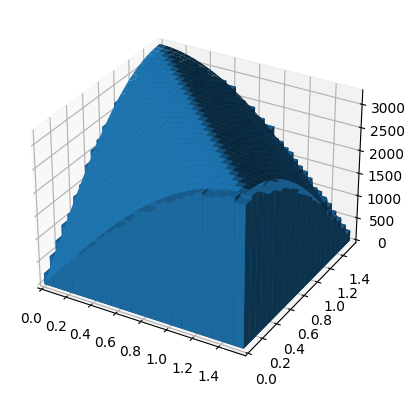

<Figure size 640x480 with 0 Axes>

In [14]:
bins = 20


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
hist, xedges, yedges = np.histogram2d(
    samples[:,0].flatten(), 
    samples[:,1].flatten(), 
    bins=bins, 
    range=[[0, np.pi / 2], [0, np.pi / 2]]
)

length = np.pi / 2 / bins

xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0
dx = dy = np.ones_like(zpos) * length
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
plt.xlim([0, np.pi / 2])
plt.ylim([0, np.pi / 2])

def f(x, y):
    return 1/2 * np.sin(x + y) * np.square(length) * 10 ** 6 * 1.05

x = np.linspace(0, np.pi/2, 30)
y = np.linspace(0, np.pi/2, 30)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)
fig = plt.figure()
ax.plot_surface(X, Y, Z)

plt.show()

# Задание 2

## Матрица

In [43]:
matrix = np.array(
    [
        [1,3,3,10],
        [1,6,2,3],
        [1,4,3,12],
        [11,43,5,6]
    ],
)

normalized_matrix = matrix / matrix.sum()
matrix_birv_generator = MatrixBiRVGenerator(normalized_matrix, rng).sample
drv_samples = np.array(matrix_birv_generator(10**6))

def get_func(matrix):
    return matrix * 10 ** 6

def get_x(matrix):
    return list(range(len(matrix)))


## Проверка независимости критерием Пирсона

In [16]:
def drv_comp_indep_check(samples, uncond_dist, axis=0):
    chis = []

    bins = np.histogram2d(
        samples[:,0].flatten(), 
        samples[:,1].flatten(), 
        bins=4, 
        range=[[0, 4], [0, 4]]
    )[0]
    n_bins = bins.shape[axis]

    for idx in range(n_bins):

        valid_values = (bins[idx,:] if axis == 0 else bins[:,idx]).flatten()
        
        n_subsample = np.sum(valid_values)

        chis.append(
            chi_criteria(valid_values / n_subsample, uncond_dist, n_subsample)
        )
        
    return chis      

x_uncond_dist = (normalized_matrix.sum(axis=0) / normalized_matrix.sum()).flatten()
y_uncond_dist = (normalized_matrix.sum(axis=1) / normalized_matrix.sum()).flatten()

In [18]:
chi_value_median = np.median(drv_comp_indep_check(drv_samples, x_uncond_dist, 0))

print((chi_value_median))

102279.99660084883


## Распределение компонентов X и Y

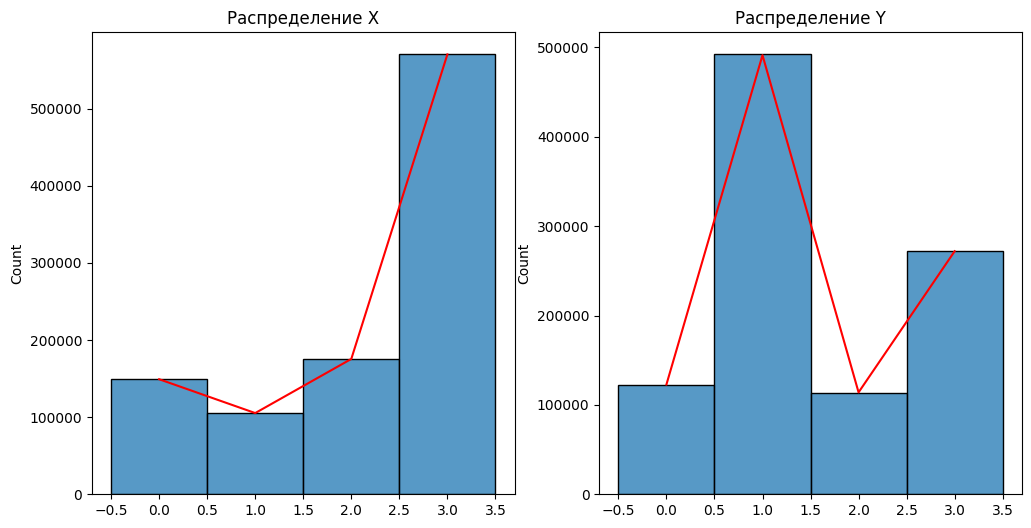

In [39]:
_, axs = plt.subplots(1,2, figsize=(12,6))

axs[0].plot(get_x(normalized_matrix.sum(axis=1)), get_func(normalized_matrix.sum(axis=1)), color='red')
axs[1].plot(get_x(normalized_matrix.sum(axis=0)), get_func(normalized_matrix.sum(axis=0)), color='red')

sns.histplot(drv_samples[:,0], ax=axs[0], discrete=True).set_title("Распределение X")
_ = sns.histplot(drv_samples[:,1], ax=axs[1], discrete=True).set_title("Распределение Y")

## Характеристики

In [20]:
def get_mean(possibilities):
    result = 0
    i = 0
    
    for item in possibilities:
        result += i * item
        i += 1

    return result

def get_var(possibilities):
    mean = get_mean(possibilities)

    result = 0
    i = 0
    
    for item in possibilities:
        result += i * i * item
        i += 1

    return result - mean * mean

mean = np.mean(drv_samples, axis=0)
var = np.var(drv_samples, axis=0)

print("Матожидание X и Y: ", mean)

x_mean_range = (mean[0] - get_delta(var[0], tests), mean[0] + get_delta(var[0], tests))
y_mean_range = (mean[1] - get_delta(var[1], tests), mean[1] + get_delta(var[1], tests))
print("Доверительный интервал матожидания X: ", x_mean_range)
print("Доверительный интервал матожидания Y: ", y_mean_range)
print()

print("Отклонение X и Y: ", var)
x_var_range = get_offset_delta(var[0], tests)
y_var_range = get_offset_delta(var[1], tests)
print("Доверительный интервал отклонения X: ", x_var_range)
print("Доверительный интервал отклонения Y: ", y_var_range)
print()

print("Теоретическое матожидание X и Y: ", [get_mean(normalized_matrix.sum(axis=1)), get_mean(normalized_matrix.sum(axis=0))])
print("Теоретическое отклонение X и Y: ", [get_var(normalized_matrix.sum(axis=1)), get_var(normalized_matrix.sum(axis=0))])
print()

print("Корреляция: \n", np.corrcoef(drv_samples[:,0], drv_samples[:,1]))


Матожидание X и Y:  [2.16765  1.535111]
Доверительный интервал матожидания X:  (2.159104400019858, 2.1761955999801423)
Доверительный интервал матожидания Y:  (1.52798798319396, 1.5422340168060398)

Отклонение X и Y:  [1.24527348 1.03797322]
Доверительный интервал отклонения X:  (1.2392592582319715, 1.2513448698131178)
Доверительный интервал отклонения Y:  (1.032960183479135, 1.0430339073374737)

Теоретическое матожидание X и Y:  [2.1666666666666665, 1.5350877192982455]
Теоретическое отклонение X и Y:  [1.2441520467836265, 1.0382425361649732]

Корреляция: 
 [[ 1.         -0.42743584]
 [-0.42743584  1.        ]]


## 3D Гистограмма

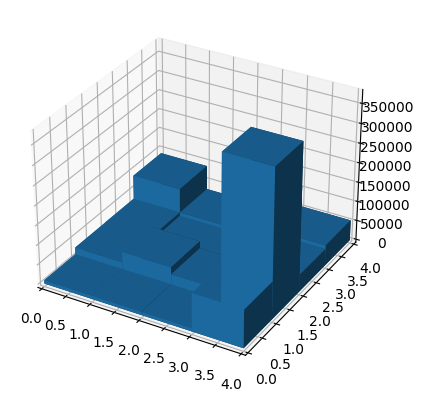

In [ ]:
bins = 20

size = len(matrix)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
hist, xedges, yedges = np.histogram2d(
    drv_samples[:,0].flatten(), 
    drv_samples[:,1].flatten(), 
    bins=size, 
    range=[[0, size], [0, size]]
)

length = 1

xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)
dx = dy = np.ones_like(zpos) * length
dz = hist.ravel()
plt.xlim([0, size])
plt.ylim([0, size])

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True)

plt.show()